In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import hpgeom
import numba
import tqdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
_ed = fitsio.read("des_exposure_data.fits")

In [3]:
_ed = np.sort(_ed, order="mjd_obs")

In [4]:
_ed.shape

(100802,)

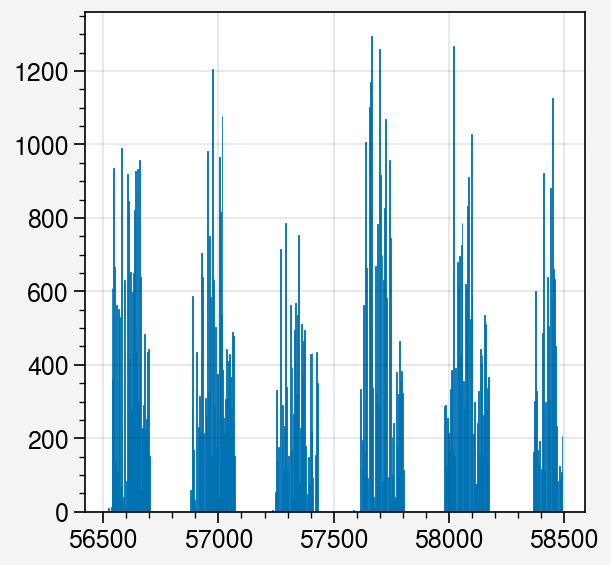

In [5]:
fig, axs = pplt.subplots()

axs.hist(_ed["mjd_obs"], bins=500);

In [71]:
from silly_cal.models import nights_with_mirror_rho

nside = 1024
nside = 512

bmsk = (_ed["band"] == "r") | (_ed["band"] == "r")
fd = nights_with_mirror_rho.gen_fake_data(
    # edata=_ed[bmsk],
    # edata=_ed[(_ed["mjd_obs"] < 57200) & bmsk],
    edata=_ed[(_ed["mjd_obs"] > 57900) & bmsk],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 58300) & bmsk],
    nside=nside,
    seed=None,
    target_nstar=20e6,
    period=365,
)

<a list of 1 Line2D objects>

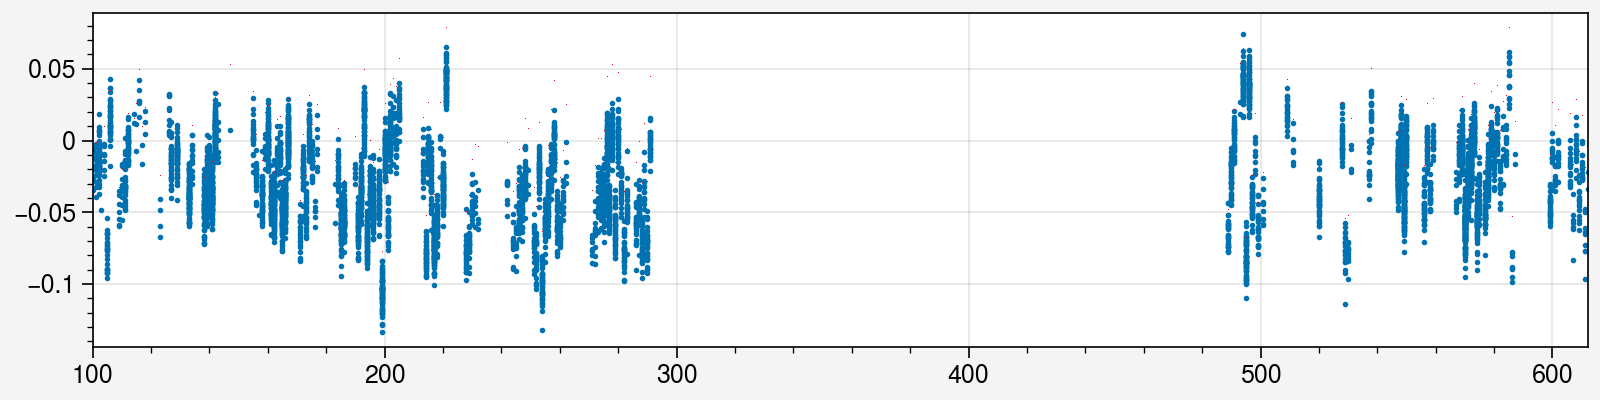

In [72]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")

# axs.format(ylim=(-1.5, 0.2), xlim=(0, 50))

## Optimize the Loss

In [73]:
# from silly_cal.optimizers import run_amsgrad, run_laprop

# from functools import partial

# pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
# grad = np.zeros_like(pars)
# nt = numba.get_num_threads()
# tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

# def ofun(pars):
#     return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

# ores = run_laprop(ofun, pars, 1e-3, 10000)
# ores

In [74]:
from scipy.optimize import minimize
from functools import partial

pars = nights_with_mirror_rho.gen_guess(fd["opt_kwargs"], eps=1e-4)
grad = np.zeros_like(pars)
nt = numba.get_num_threads()
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

def ofun(pars):
    return nights_with_mirror_rho.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[0]

def ofun_jac(pars):
    return nights_with_mirror_rho.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[1].copy()

bounds = [(None, None) for g in grad]
bounds[0] = (0, 1.0)

res = minimize(
    ofun, pars, method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10), bounds=bounds
)
res = minimize(
    ofun, res["x"], method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10), bounds=bounds
)
res

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       406297     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74307D+00    |proj g|=  7.65126D+00

At iterate   10    f=  1.50350D+00    |proj g|=  2.74229D-01

At iterate   20    f=  1.01719D+00    |proj g|=  2.39632D-01

At iterate   30    f=  9.64053D-01    |proj g|=  1.07736D-01

At iterate   40    f=  9.42454D-01    |proj g|=  2.57100D-01

At iterate   50    f=  8.36024D-01    |proj g|=  3.18221D-01

At iterate   60    f=  7.78436D-01    |proj g|=  2.67616D-01

At iterate   70    f=  7.70953D-01    |proj g|=  3.61422D-02

At iterate   80    f=  7.68133D-01    |proj g|=  4.29831D-02

At iterate   90    f=  7.66482D-01    |proj g|=  6.73522D-02

At iterate  100    f=  7.61764D-01    |proj g|=  4.75505D-02

At iterate  110    f=  7.59084D-01    |proj g|=  4.52083D-02

At iterate  120    f=  7.57437D-01    |proj g|=  4.75196D-02

At iterate  130    f=  7.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       406297     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46246D-01    |proj g|=  1.35093D-02

At iterate   10    f=  7.46246D-01    |proj g|=  5.12866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     18     29     18     0     0   3.311D-03   7.462D-01
  F =  0.74624585700695667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.7462458570069567
        x: [ 6.027e-01 -2.122e-01 ... -2.110e-02  1.249e-02]
      nit: 18
      jac: [ 1.126e-03  3.311e-03 ...  2.483e-06  1.706e-06]
     nfev: 29
     njev: 29
 hess_inv: <406297x406297 LbfgsInvHessProduct with dtype=float64>

In [75]:
fdd = fd["data"]

In [76]:
(fd["params"]["rho_night"], res["x"][0]), (fdd["true_tel_eff"], res["x"][1:1+fdd["true_tel_eff"].shape[0]])

((0.891, 0.6026918903569901),
 (array([-0.15554911, -0.15286853]), array([-0.21220333, -0.22677232])))

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [78]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [79]:
est_star = res["x"][1+fd["opt_kwargs"]["nyear"] + fd["opt_kwargs"]["nnight"]+fd["opt_kwargs"]["nexp"]:]

dstar = (est_star - fdd["true_star"]) * 1e3

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [86]:
msk = fdd["star_dec"] < -40.0

np.mean(dstar[msk]), np.std(dstar[msk]), np.mean(dstar[~msk]), np.std(dstar[~msk])

(0.03213351883959052,
 7.528116567866619,
 -0.00931787937669263,
 7.896556223204717)

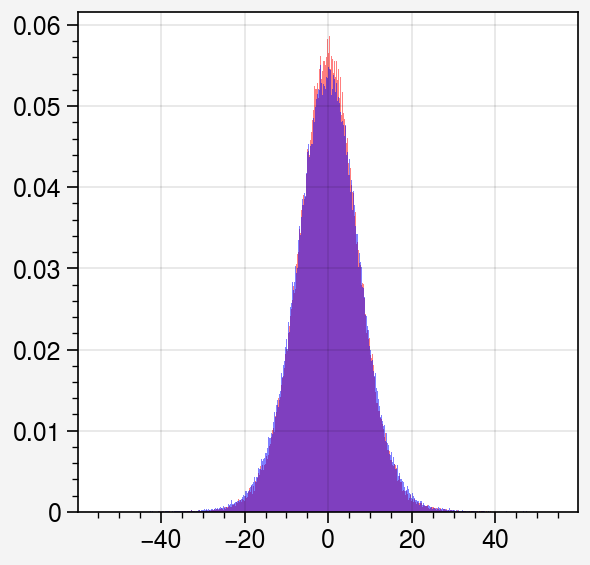

In [87]:
fig, axs = pplt.subplots()

axs.hist(dstar[msk], bins=500, density=True, alpha=0.5, color="r")
axs.hist(dstar[~msk], bins=500, density=True, alpha=0.5, color="b");

In [82]:
from mattspy.stats import mad

fac = np.sqrt(fd["params"]["target_nstar"] / dstar.shape[0])

np.mean(dstar), mad(dstar), mad(dstar) * fac

(0.009490672326640377, 7.284636630168676, 51.54806135583756)

In [83]:
def get_true_zp(fd):
    rho_night = fd["params"]["rho_night"]
    true_zp_night = fd["data"]["true_zp_night"]
    true_zp_nse = fd["data"]["true_zp_nse"]
    true_tel_eff = fd["data"]["true_tel_eff"]
    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * true_zp_night[inv_unight]
        + rho_night_fac * true_zp_nse
        + true_tel_eff[inv_uyear] * night_in_year
    )


def get_est_zp(pars, fd):
    nnight = fd["data"]["true_zp_night"].shape[0]
    nexp = fd["data"]["true_zp_nse"].shape[0]
    nyear = fd["data"]["true_tel_eff"].shape[0]
    
    rho_night = pars[0]
    tel_eff = pars[1:1+nyear]
    zp_night = pars[1+nyear:1+nyear+nnight]
    zp_nse = pars[1+nyear+nnight:1+nyear+nnight+nexp]

    night_in_year = fd["data"]["night_in_year"]
    inv_unight = fd["data"]["inv_unight"]
    inv_uyear = fd["data"]["inv_uyear"]
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    return (
        sqrt_rho_night * zp_night[inv_unight]
        + rho_night_fac * zp_nse
        + tel_eff[inv_uyear] * night_in_year
    )

true_zp = get_true_zp(fd)
est_zp = get_est_zp(res["x"], fd)

dzp = (est_zp - true_zp) * 1e3

from mattspy.stats import mad

np.mean(dzp), mad(dzp)

(-0.010515755228005474, 1.1994900004185625)

In [84]:
_nside = 32

exp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)
nexp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)

exp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], dzp, operation="add")
nexp_hmap.update_values_pos(fd["data"]["exp_ra"], fd["data"]["exp_dec"], 1.0, operation="add")

exp_hmap_vals = exp_hmap.get_values_pix(exp_hmap.valid_pixels)
nexp_hmap_vals = nexp_hmap.get_values_pix(nexp_hmap.valid_pixels)

exp_hmap_vals /= nexp_hmap_vals

_ra, _dec = exp_hmap.valid_pixels_pos()

mn_exp_hmap = hsp.HealSparseMap.make_empty(32, _nside, np.float64)
mn_exp_hmap.update_values_pos(_ra, _dec, exp_hmap_vals)

(<matplotlib.colorbar.Colorbar at 0x142c12710>,
 <AxesHostAxes:xlabel='exposure $\\Delta mag$ [mmag]'>)

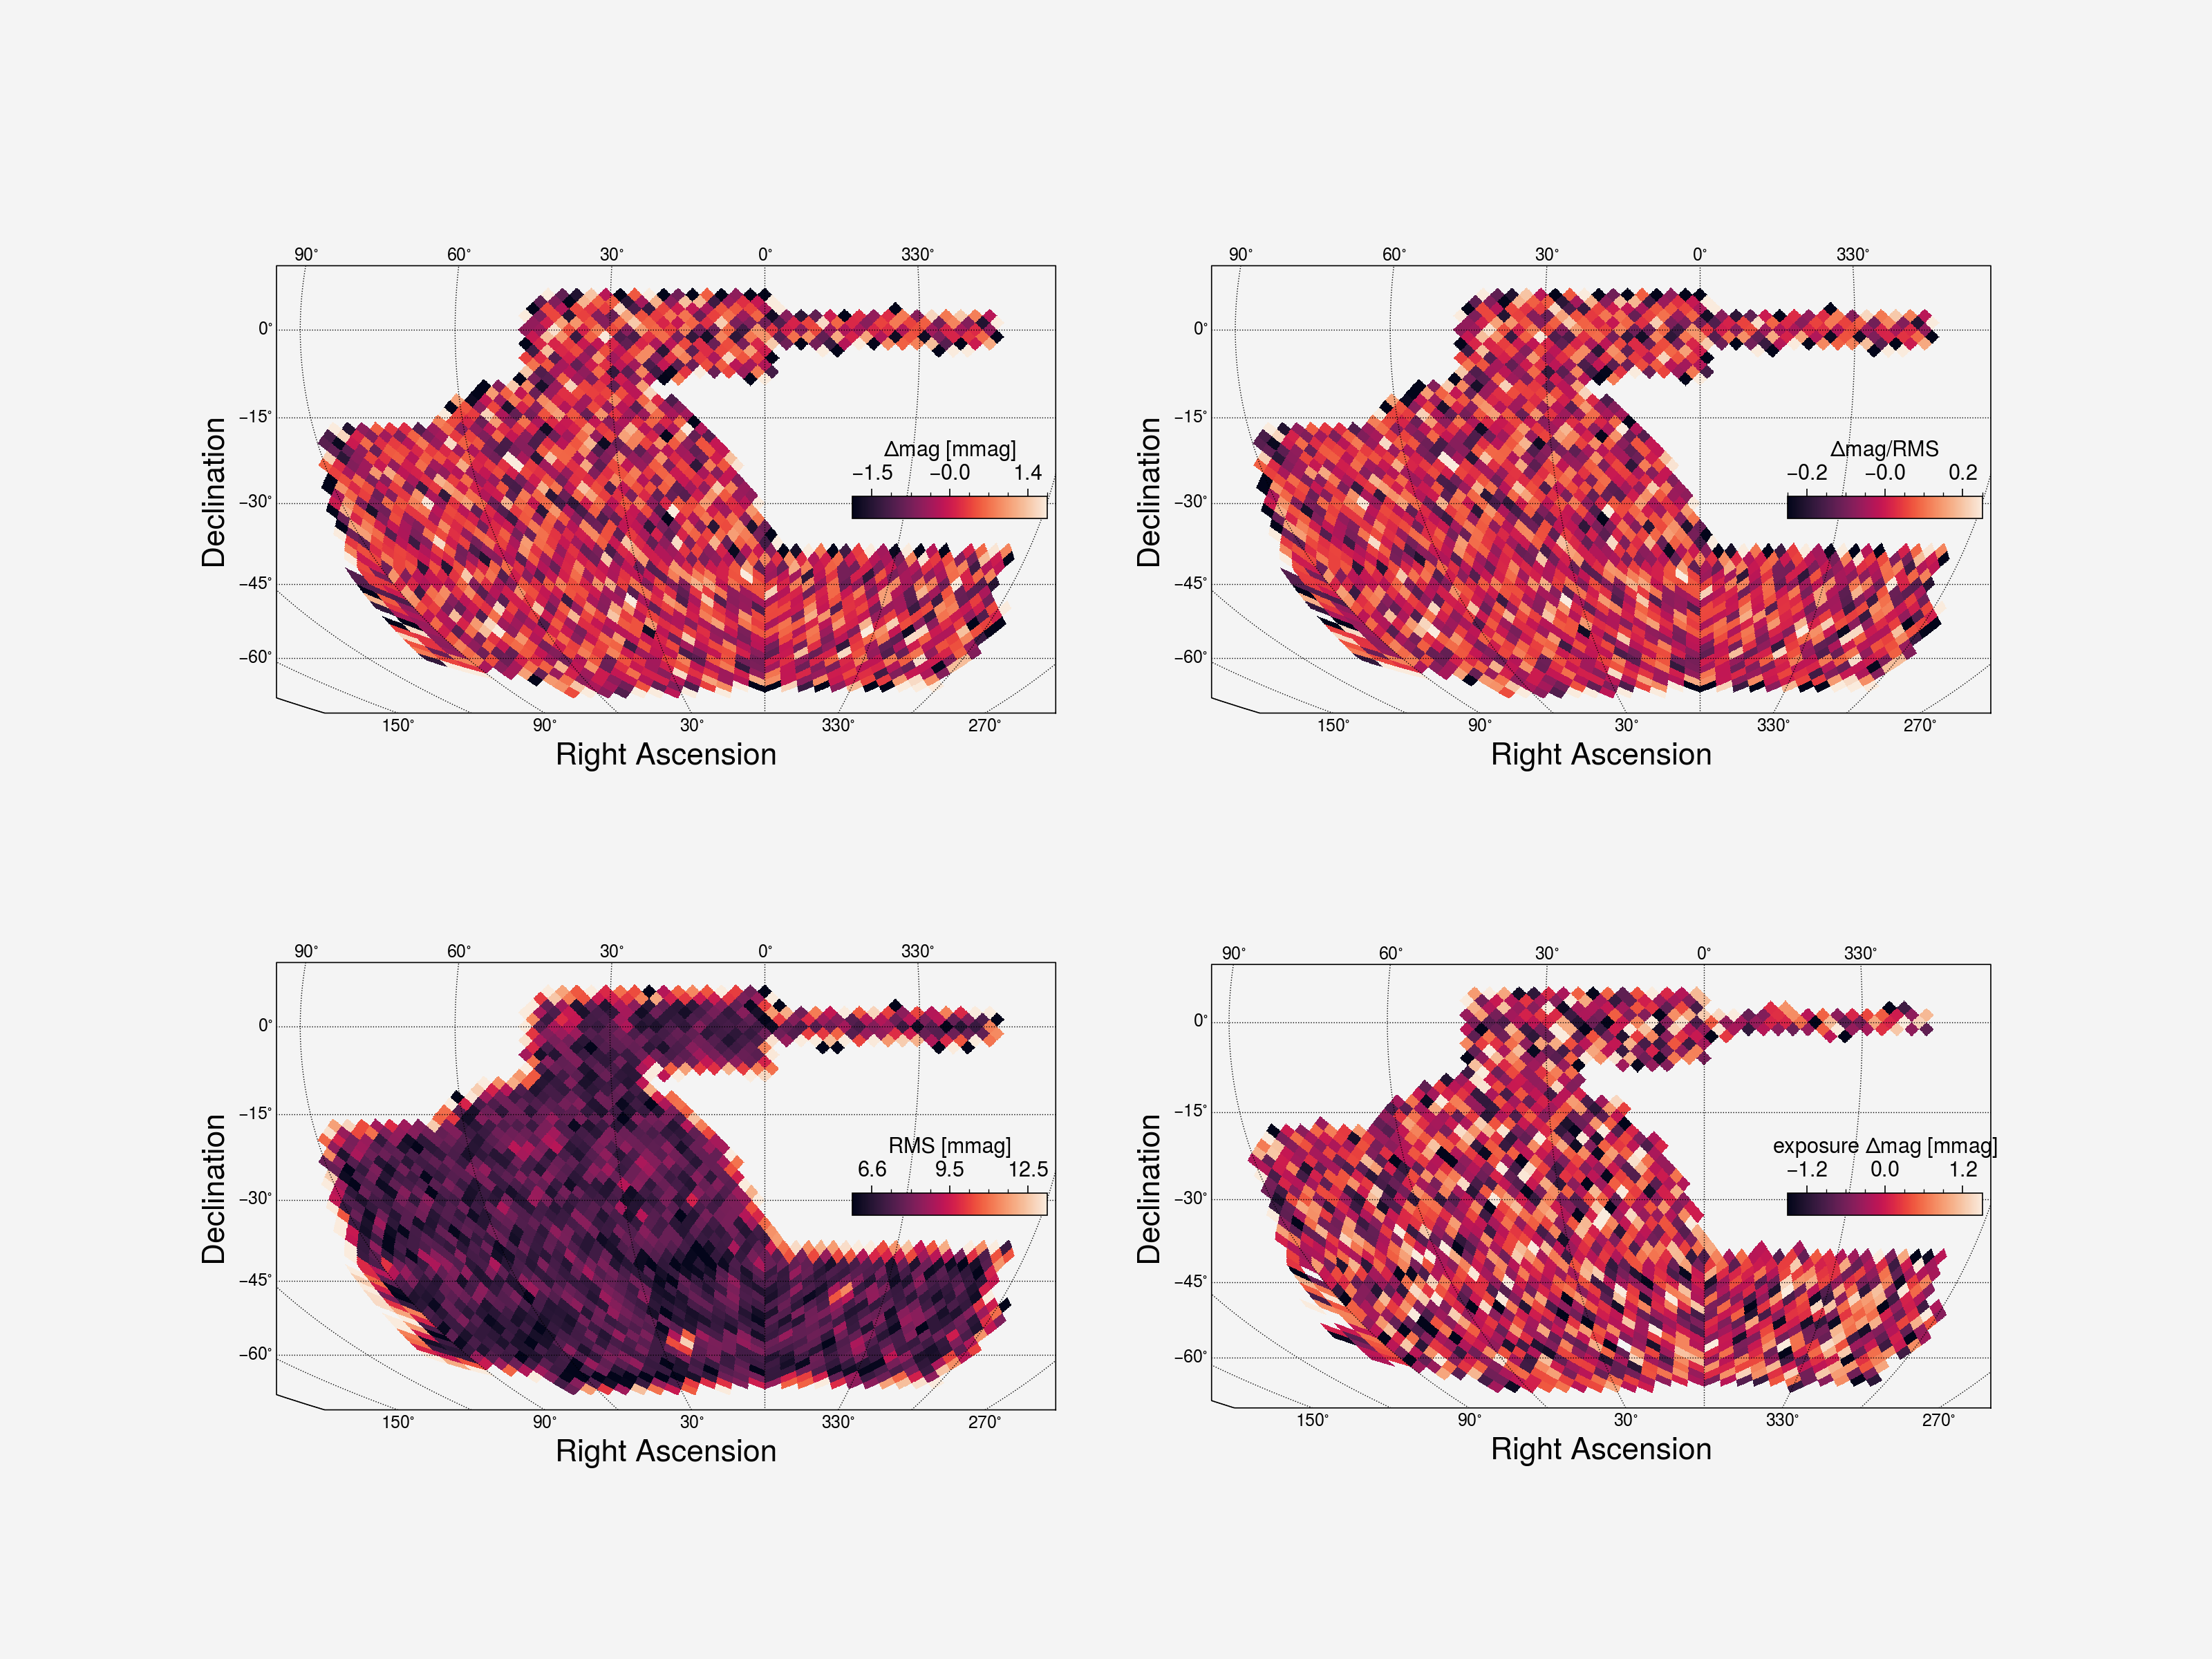

In [85]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12), squeeze=False)

_nside = 32
mn_map = hmap.degrade(_nside, reduction="mean")
sd_map = hmap.degrade(_nside, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(mn_map, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[0, 1])
sp.draw_hspmap(mn_map / mean_sd, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag/RMS$")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map, cmap="rocket")
sp.draw_inset_colorbar(label="RMS [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 1])
sp.draw_hspmap(mn_exp_hmap, cmap="rocket")
sp.draw_inset_colorbar(label="exposure $\Delta mag$ [mmag]")